In [1]:
!pip install svgwrite cairosvg


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import svgwrite

In [44]:
# Function to read CSV files and parse paths
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

In [4]:
# Colors for visualization
colours = ['red', 'blue', 'green', 'orange', 'purple']

In [5]:
# Function to plot paths
def plot(paths_XYs, show_vertices=False):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
            if show_vertices:
                ax.scatter(XY[:, 0], XY[:, 1], c=c)
    ax.set_aspect('equal')
    plt.show()

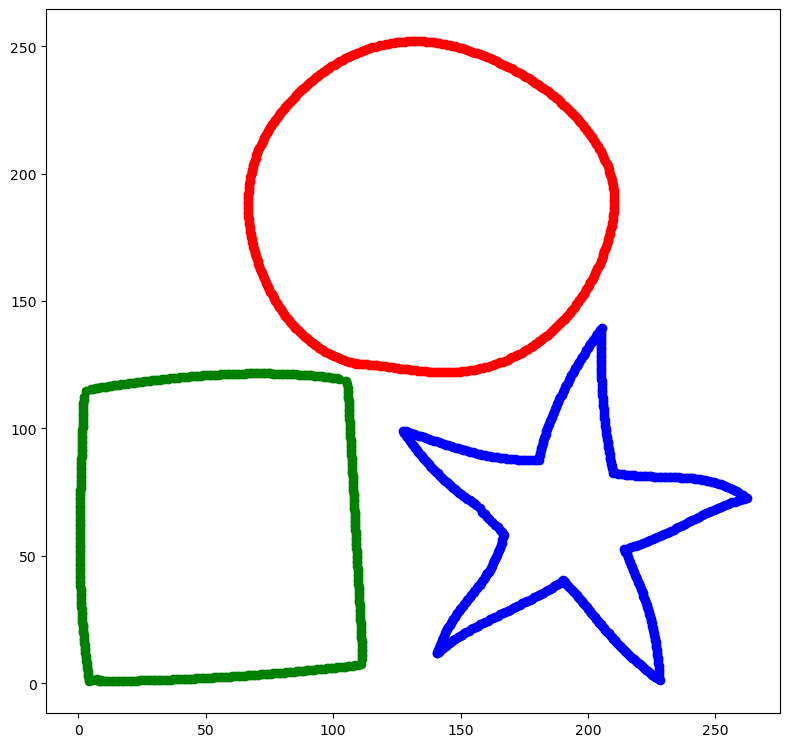

In [6]:
# Reading the input paths
input_paths = read_csv('isolated.csv')

# Plotting the input paths
plot(input_paths, show_vertices=True)

# Regularizing the curves 

In [46]:
import numpy as np
from scipy.interpolate import splprep, splev
from scipy.spatial import distance

def regularize_polylines(paths_XYs, num_points=100, smoothness=0):
    regularized_paths = []
    for path_XYs in paths_XYs:
        regularized_path = []
        for XY in path_XYs:
            # Check if the curve is already closed
            is_closed = np.allclose(XY[0], XY[-1])
            
            # If not closed, decide whether to close it based on the distance between endpoints
            if not is_closed:
                end_distance = distance.euclidean(XY[0], XY[-1])
                avg_segment_length = np.mean([distance.euclidean(XY[i], XY[i+1]) for i in range(len(XY)-1)])
                if end_distance < 2 * avg_segment_length:
                    XY = np.vstack([XY, XY[0]])
                    is_closed = True

            # Determine if the shape has sharp corners
            angles = compute_angles(XY)
            has_sharp_corners = np.any(angles < np.radians(120))  # Adjust this threshold as needed

            if has_sharp_corners:
                # For shapes with sharp corners, use linear interpolation
                t = np.linspace(0, 1, len(XY))
                t_new = np.linspace(0, 1, num_points)
                interpolated = np.column_stack([np.interp(t_new, t, XY[:, i]) for i in range(2)])
            else:
                # For smooth shapes, use spline interpolation
                tck, u = splprep(XY.T, s=smoothness, per=is_closed)
                u_new = np.linspace(0, 1, num_points)
                interpolated = np.column_stack(splev(u_new, tck))

            regularized_path.append(interpolated)
        regularized_paths.append(regularized_path)
    return regularized_paths

In [47]:
def compute_angles(points):
    vectors = np.diff(points, axis=0)
    vectors = vectors / np.linalg.norm(vectors, axis=1)[:, np.newaxis]
    dot_products = np.sum(vectors[:-1] * vectors[1:], axis=1)
    angles = np.arccos(np.clip(dot_products, -1.0, 1.0))
    return angles



In [48]:
regularized_paths = regularize_polylines(input_paths)


In [54]:
import cv2
def detect_shapes(regularized_paths):
    shape_labels = []
    for path in regularized_paths:
        for XY in path:
            approx = cv2.approxPolyDP(XY.astype(np.float32), 0.04 * cv2.arcLength(XY.astype(np.float32), True), True)
            vertices = len(approx)
            if vertices == 3:
                shape_labels.append("Triangle")
            elif vertices == 4:
                x, y, w, h = cv2.boundingRect(approx)
                aspect_ratio = float(w) / h
                if 0.95 <= aspect_ratio <= 1.05:
                    shape_labels.append("Square")
                else:
                    shape_labels.append("Rectangle")
            elif vertices == 5:
                shape_labels.append("Pentagon")
            elif vertices == 6:
                shape_labels.append("Hexagon")
            elif vertices == 10:
                shape_labels.append("Star")
            else:
                shape_labels.append("Circle")
    return shape_labels

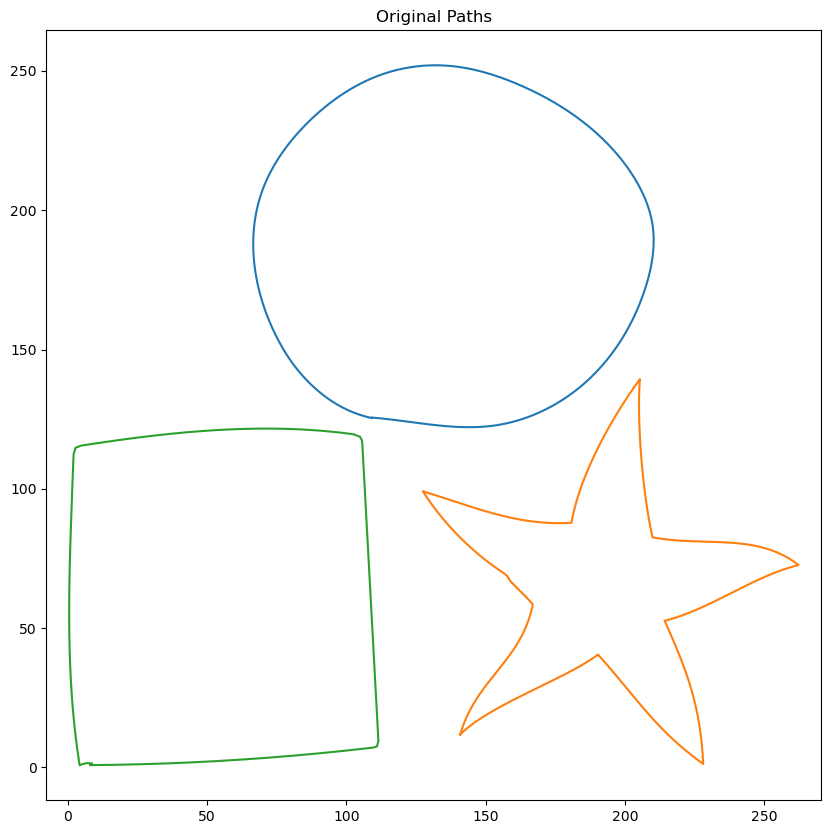

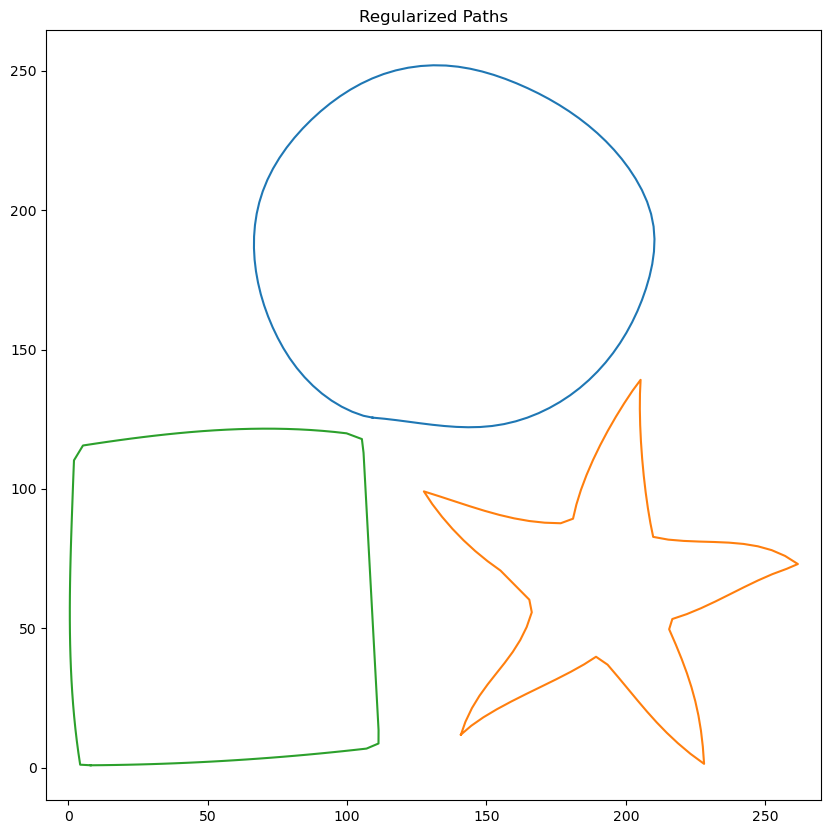

In [55]:
import matplotlib.pyplot as plt

def plot_paths(paths, title):
    plt.figure(figsize=(10, 10))
    for path in paths:
        for curve in path:
            plt.plot(curve[:, 0], curve[:, 1])
    plt.title(title)
    plt.axis('equal')
    plt.show()

plot_paths(input_paths, "Original Paths")
plot_paths(regularized_paths, "Regularized Paths")

In [56]:
# Function to convert polylines to Bezier paths
def polylines_to_bezier(paths_XYs):
    bezier_paths = []
    for path_XYs in paths_XYs:
        bezier_path = []
        for XY in path_XYs:
            bezier_path.append(XY)
        bezier_paths.append(bezier_path)
    return bezier_paths

# Convert the regularized paths to Bezier paths
bezier_paths = polylines_to_bezier(regularized_paths)

In [57]:
def svg_to_png(svg_path, png_path):
    svg_image = cv2.imread(svg_path, cv2.IMREAD_UNCHANGED)
    cv2.imwrite(png_path, svg_image)

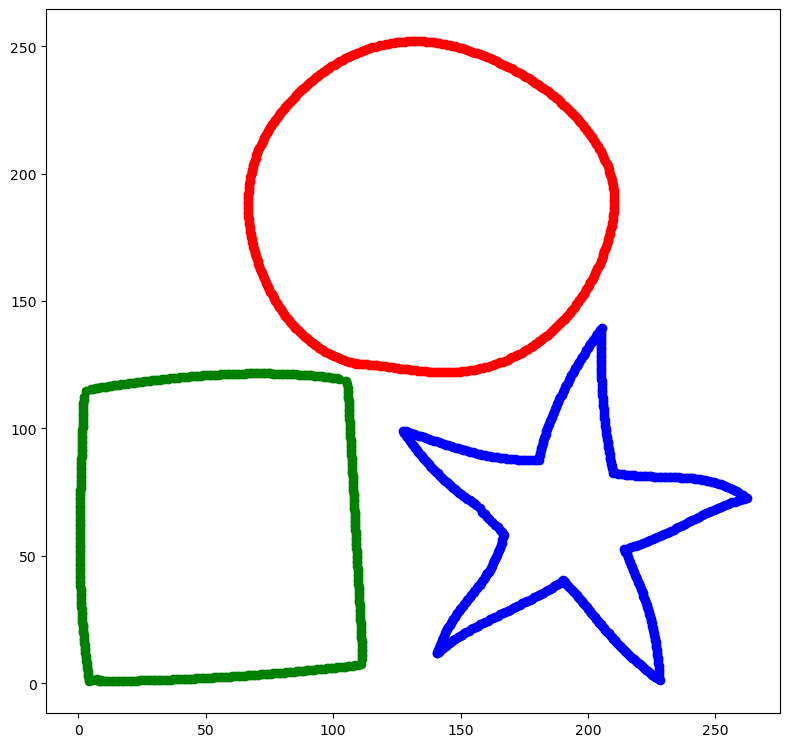

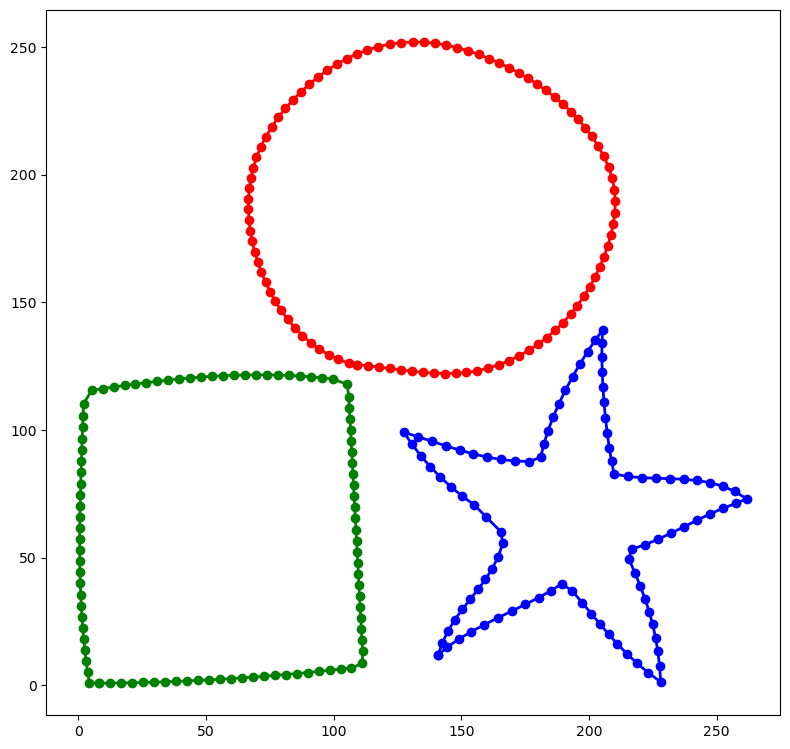

Detected Shapes: ['Circle', 'Star', 'Rectangle']


In [58]:
# Read input CSV file

input_paths = read_csv('isolated.csv')

# Plotting the input paths
plot(input_paths, show_vertices=True)

# Regularize the input paths
regularized_paths = regularize_polylines(input_paths)

# Plotting the regularized paths
plot(regularized_paths, show_vertices=True)

# Detect shapes in the regularized paths
shape_labels = detect_shapes(regularized_paths)
print("Detected Shapes:", shape_labels)

# Convert the regularized paths to Bezier paths
bezier_paths = polylines_to_bezier(regularized_paths)


In [ ]:
def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)
    # Create a new SVG drawing
    dwg = svgwrite.Drawing(svg_path, profile='tiny',
                           shape_rendering='crispEdges')
    group = dwg.g()
    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))
        group.add(dwg.path(d=path_data, fill=c,
                           stroke='none', stroke_width=2))
    dwg.add(group)
    dwg.save()
    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))
    cairosvg.svg2png(url=svg_path, write_to=png_path,
                     parent_width=W, parent_height=H,
                     output_width=fact * W, output_height=fact * H,
                     background_color='white')

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from skimage.filters import gaussian
from skimage.restoration import denoise_bilateral

In [60]:
# Load the data
data = pd.read_csv('isolated.csv', header=None)

# Assuming the first two columns are x and y
x = data.iloc[:, 2].values  # Adjust column index based on your data structure
y = data.iloc[:, 3].values  # Adjust column index based on your data structure

In [61]:
# Apply Gaussian smoothing
sigma = 2  # Adjust sigma for smoothing level
y_gaussian = gaussian_filter1d(y, sigma)

In [75]:
# Apply median filtering
size = 5  # Adjust size for the filter window
y_median = median_filter(y, size=size)

In [76]:
# Apply bilateral filtering
y_bilateral = denoise_bilateral(y, sigma_color=0.05, sigma_spatial=15, multichannel=False)

C:\Users\Sumiran Grover\AppData\Local\Temp\ipykernel_16036\902343852.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_bilateral`. It will be removed in version 1.0. Please use `channel_axis` instead.
  y_bilateral = denoise_bilateral(y, sigma_color=0.05, sigma_spatial=15, multichannel=False)


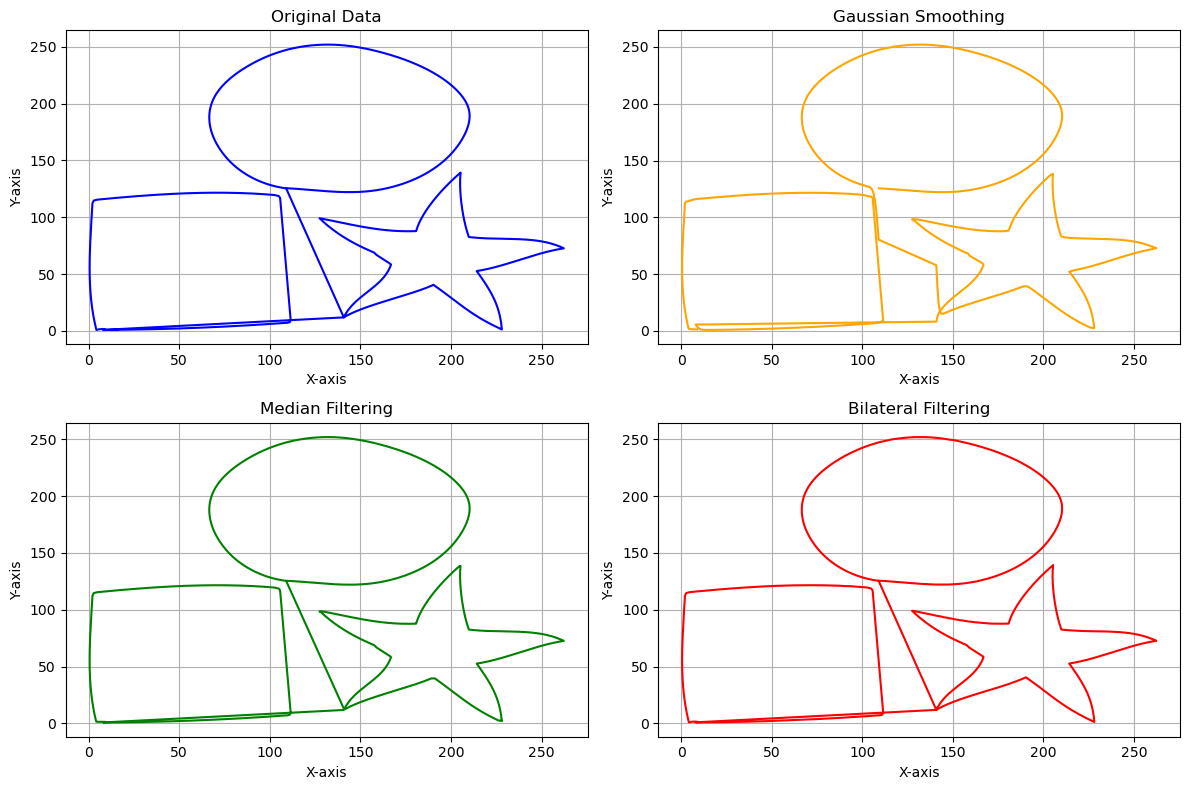

In [77]:
# Plotting the original and smoothed curves
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(x, y, label='Original Data', color='blue')
plt.title('Original Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(x, y_gaussian, label='Gaussian Smoothing', color='orange')
plt.title('Gaussian Smoothing')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(x, y_median, label='Median Filtering', color='green')
plt.title('Median Filtering')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(x, y_bilateral, label='Bilateral Filtering', color='red')
plt.title('Bilateral Filtering')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid()

plt.tight_layout()
plt.show()

# Symmetry Detection

In [ ]:
def load_curve_data(file_path):
    """Load curve data from a CSV file."""
    data = pd.read_csv(file_path, header=None)
    # Assuming the data has four columns, extract the relevant ones
    # Here we assume the last two columns are x and y coordinates
    x = data.iloc[:, 2].values
    y = data.iloc[:, 3].values
    return np.column_stack((x, y))  # Combine x and y into a single arra

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff

def find_symmetry_axes(curve):
    x_min, y_min = np.min(curve, axis=0)
    x_max, y_max = np.max(curve, axis=0)
    center_x, center_y = (x_min + x_max) / 2, (y_min + y_max) / 2
    
    axes = [
        ('vertical', np.array([center_x, 0]), np.array([center_x, 1])),
        ('horizontal', np.array([0, center_y]), np.array([1, center_y])),
        ('diagonal', np.array([x_min, y_min]), np.array([x_max, y_max])),
        ('anti-diagonal', np.array([x_min, y_max]), np.array([x_max, y_min]))
    ]
    return axes


In [52]:
def reflect_curve(curve, p1, p2):
    v = p2 - p1
    w = curve - p1
    proj = p1 + (np.dot(w, v) / np.dot(v, v))[:, np.newaxis] * v
    return 2 * proj - curve


In [53]:
def check_symmetry(curve, threshold=0.05):
    axes = find_symmetry_axes(curve)
    symmetric_axes = []
    
    for axis_name, p1, p2 in axes:
        reflected = reflect_curve(curve, p1, p2)
        distance = directed_hausdorff(curve, reflected)[0]
        
        if distance < threshold * np.ptp(curve):
            symmetric_axes.append((axis_name, p1, p2))
    
    return symmetric_axes


In [54]:
def analyze_curves(input_paths, num_points=100, smoothness=0, symmetry_threshold=0.05):
    regularized_paths = [load_curve_data(path) for path in input_paths]  # Load curves from paths
    results = []
    
    for path in regularized_paths:
        path_results = []
        symmetric_axes = check_symmetry(path, symmetry_threshold)
        path_results.append((path, symmetric_axes))
        results.append(path_results)
    
    return results

In [55]:
def plot_results(results):
    for path_result in results:
        plt.figure(figsize=(12, 4 * len(path_result)))
        for i, (curve, axes) in enumerate(path_result):
            plt.subplot(len(path_result), 1, i + 1)
            plt.plot(curve[:, 0], curve[:, 1], label='Regularized Curve')
            
            for axis_name, p1, p2 in axes:
                plt.plot([p1[0], p2[0]], [p1[1], p2[1]], '--', label=f'{axis_name.capitalize()} Symmetry')
            
            plt.legend()
            plt.title(f'Curve {i + 1} Symmetry Analysis')
            plt.axis('equal')
        plt.tight_layout()
        plt.show()

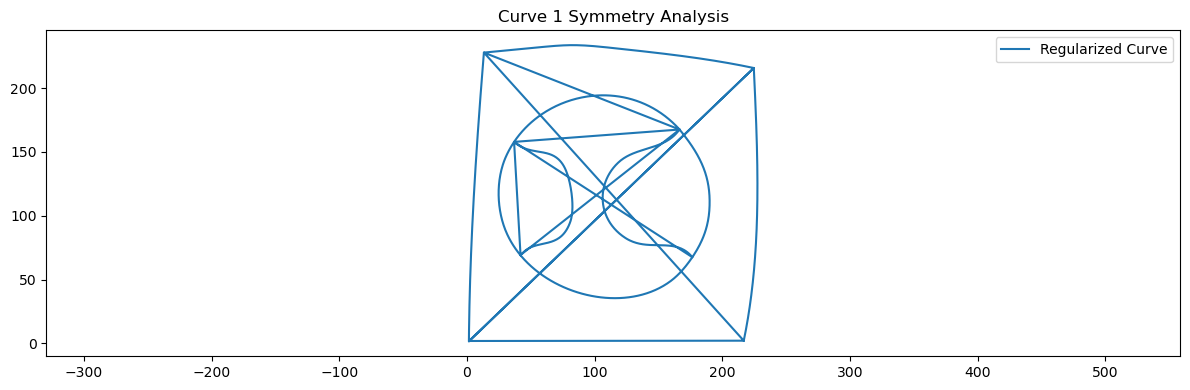

In [56]:
# Main execution
file_path = 'frag0.csv'  # Path to your CSV file
input_paths = [file_path]  # Create a list of paths to analyze
symmetry_results = analyze_curves(input_paths)

# Visualize symmetry results
plot_results(symmetry_results)

Mean Euclidean Distance: 125.66963191734528
Hausdorff Distance: 37.34539312858209


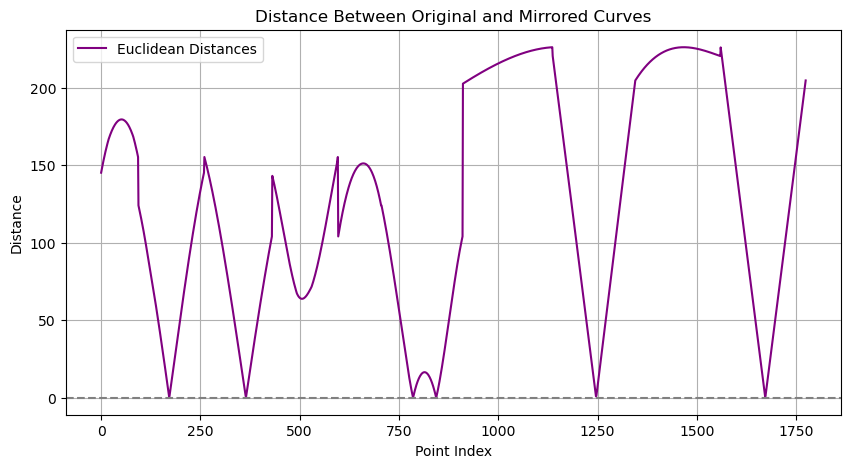

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV
data = pd.read_csv('frag0.csv', header=None)

# Assuming the first two columns are x and y
x = data.iloc[:, 2].values  # Adjust column index based on your data structure
y = data.iloc[:, 3].values  # Adjust column index based on your data structure

# Determine the symmetry axis (for example, vertical)
midpoint_x = (x.max() + x.min()) / 2

# Reflect the curve across the vertical axis
x_reflected = midpoint_x - (x - midpoint_x)
y_reflected = y.copy()  # Assuming y-values remain the same for vertical reflection

# Calculate Euclidean distances between original and reflected curves
distances = np.sqrt((x - x_reflected) ** 2 + (y - y_reflected) ** 2)

# Calculate Hausdorff distance
def hausdorff_distance(a, b):
    dists = np.zeros((len(a), len(b)))
    for i in range(len(a)):
        for j in range(len(b)):
            dists[i, j] = np.sqrt((a[i, 0] - b[j, 0]) ** 2 + (a[i, 1] - b[j, 1]) ** 2)
    return max(np.max(np.min(dists, axis=1)), np.max(np.min(dists, axis=0)))

# Prepare data for Hausdorff distance calculation
original_points = np.column_stack((x, y))
reflected_points = np.column_stack((x_reflected, y_reflected))

hausdorff_dist = hausdorff_distance(original_points, reflected_points)

# Print the results
print(f"Mean Euclidean Distance: {np.mean(distances)}")
print(f"Hausdorff Distance: {hausdorff_dist}")

# Visualize the distances
plt.figure(figsize=(10, 5))
plt.plot(distances, label='Euclidean Distances', color='purple')
plt.title('Distance Between Original and Mirrored Curves')
plt.xlabel('Point Index')
plt.ylabel('Distance')
plt.axhline(y=0, color='gray', linestyle='--')
plt.grid()
plt.legend()
plt.show()

Max Euclidean Distance: 225.99026489257807
Mean Euclidean Distance: 125.66963191734528
Binary Symmetry Score: 0
Continuous Symmetry Score: 0.00


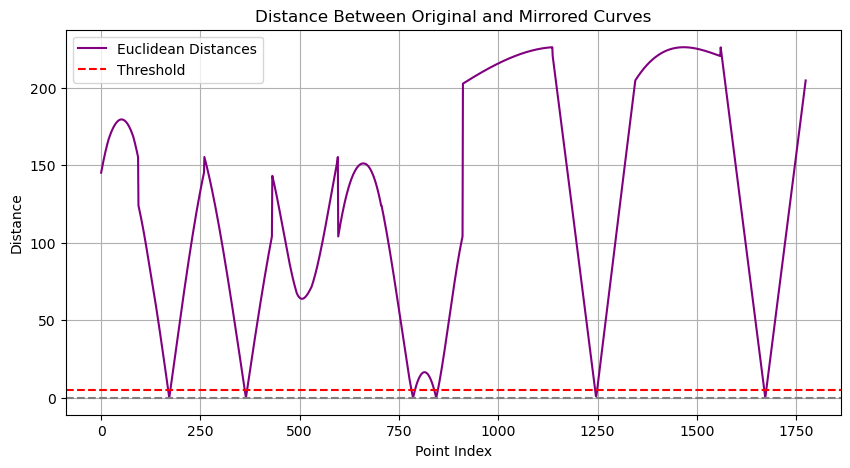

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV
data = pd.read_csv('frag0.csv', header=None)

# Assuming the first two columns are x and y
x = data.iloc[:, 2].values  # Adjust column index based on your data structure
y = data.iloc[:, 3].values  # Adjust column index based on your data structure

# Determine the symmetry axis (for example, vertical)
midpoint_x = (x.max() + x.min()) / 2

# Reflect the curve across the vertical axis
x_reflected = midpoint_x - (x - midpoint_x)
y_reflected = y.copy()  # Assuming y-values remain the same for vertical reflection

# Calculate Euclidean distances between original and reflected curves
distances = np.sqrt((x - x_reflected) ** 2 + (y - y_reflected) ** 2)

# Define a threshold for symmetry
threshold = 5.0  # Adjust this value based on your data characteristics

# Calculate the symmetry score
max_distance = np.max(distances)
mean_distance = np.mean(distances)

# Binary symmetry score
is_symmetric = 1 if max_distance < threshold else 0

# Continuous symmetry score (normalized)
continuous_score = max(0, 1 - (mean_distance / threshold))  # Score between 0 and 1

# Print the results
print(f"Max Euclidean Distance: {max_distance}")
print(f"Mean Euclidean Distance: {mean_distance}")
print(f"Binary Symmetry Score: {is_symmetric}")
print(f"Continuous Symmetry Score: {continuous_score:.2f}")

# Optional: Visualize the distances
plt.figure(figsize=(10, 5))
plt.plot(distances, label='Euclidean Distances', color='purple')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Distance Between Original and Mirrored Curves')
plt.xlabel('Point Index')
plt.ylabel('Distance')
plt.axhline(y=0, color='gray', linestyle='--')
plt.grid()
plt.legend()
plt.show()

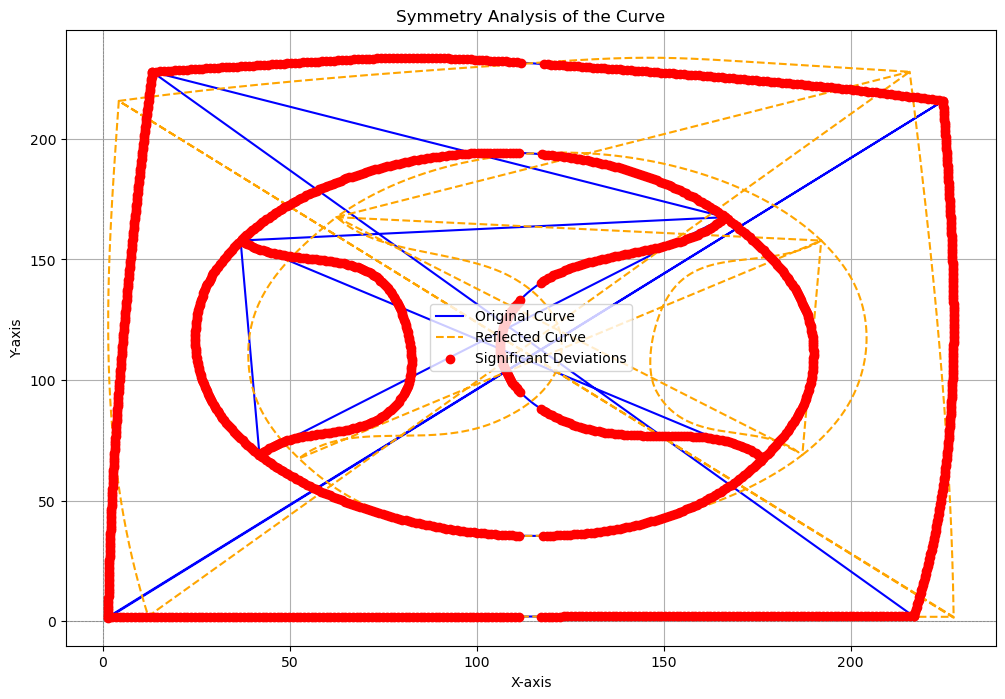

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV
data = pd.read_csv('frag0.csv', header=None)

# Assuming the first two columns are x and y
x = data.iloc[:, 2].values  # Adjust column index based on your data structure
y = data.iloc[:, 3].values  # Adjust column index based on your data structure

# Determine the symmetry axis (for example, vertical)
midpoint_x = (x.max() + x.min()) / 2

# Reflect the curve across the vertical axis
x_reflected = midpoint_x - (x - midpoint_x)
y_reflected = y.copy()  # Assuming y-values remain the same for vertical reflection

# Calculate Euclidean distances between original and reflected curves
distances = np.sqrt((x - x_reflected) ** 2 + (y - y_reflected) ** 2)

# Define a threshold for significant deviation
deviation_threshold = 5.0  # Adjust this value based on your data characteristics

# Identify points that exceed the deviation threshold
significant_deviations = distances > deviation_threshold

# Plot the original and mirrored curves
plt.figure(figsize=(12, 8))
plt.plot(x, y, label='Original Curve', color='blue')
plt.plot(x_reflected, y_reflected, label='Reflected Curve', linestyle='--', color='orange')

# Highlight points with significant deviations
plt.scatter(x[significant_deviations], y[significant_deviations], color='red', label='Significant Deviations', zorder=5)

# Set plot details
plt.title('Symmetry Analysis of the Curve')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axhline(0, color='gray', lw=0.5, ls='--')  # Horizontal axis
plt.axvline(0, color='gray', lw=0.5, ls='--')  # Vertical axis
plt.grid()
plt.legend()
plt.show()

# Completing Incomplete Curves 

In [64]:
import cv2
import numpy as np

# Load the image
image = cv2.imread('occlusion1_rec.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def is_fully_contained(inner_contour, outer_contour):
    """ Check if inner_contour is fully contained within outer_contour. """
    return all(cv2.pointPolygonTest(outer_contour, tuple(point[0]), False) >= 0 for point in inner_contour)

def is_partially_contained(inner_contour, outer_contour):
    """ Check if inner_contour is partially contained within outer_contour. """
    # Check if any points of the inner contour are inside the outer contour
    return any(cv2.pointPolygonTest(outer_contour, tuple(point[0]), False) >= 0 for point in inner_contour)

def is_disconnected(endpoints, threshold=10):
    """ Check if the distance between endpoints is greater than a threshold. """
    return np.linalg.norm(np.array(endpoints[0]) - np.array(endpoints[1])) > threshold

# Process each contour
for i, contour in enumerate(contours):
    # Approximate the contour
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Get endpoints
    endpoints = [tuple(approx[0][0]), tuple(approx[-1][0])]

    # Classify occlusion (simplified logic)
    occlusion_type = 'Disconnected'
    for j, other_contour in enumerate(contours):
        if i != j:  # Avoid comparing the contour with itself
            if is_fully_contained(approx, other_contour):
                occlusion_type = 'Fully Contained'
                break
            elif is_partially_contained(approx, other_contour):
                occlusion_type = 'Partially Contained'
                break

    print(f'Contour {i}: Endpoints: {endpoints}, Occlusion Type: {occlusion_type}')

Contour 0: Endpoints: [(399, 15), (539, 101)], Occlusion Type: Disconnected


In [65]:
from scipy.interpolate import splprep, splev

In [66]:


def complete_fully_contained(inner_contour, outer_contour):
    """ Completes the missing portion of a fully contained curve. """
    # Get the endpoints of the inner contour
    endpoints = [tuple(inner_contour[0][0]), tuple(inner_contour[-1][0])]
    
    # Extract x and y coordinates of the endpoints
    x_inner = [point[0][0] for point in inner_contour]
    y_inner = [point[0][1] for point in inner_contour]

    # Generate control points for the B-spline
    # Here we take the endpoints and add a midpoint for a smoother curve
    control_points = [endpoints[0], 
                      ((endpoints[0][0] + endpoints[1][0]) / 2, (endpoints[0][1] + endpoints[1][1]) / 2), 
                      endpoints[1]]

    # Fit a B-spline to the control points
    tck, u = splprep(control_points, s=0)
    
    # Evaluate the B-spline at a set of points
    new_points = splev(np.linspace(0, 1, 100), tck)

    # Create a new contour from the B-spline points
    completed_curve = np.array(list(zip(new_points[0], new_points[1])), dtype=np.int32)

    return completed_curve

In [67]:
import cv2
# Load the image and preprocess
image = cv2.imread('occlusion1_rec.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

In [68]:
# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Process each contour
for i, contour in enumerate(contours):
    # Approximate the contour
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Check if the contour is fully contained within another
    for j, outer_contour in enumerate(contours):
        if i != j and is_fully_contained(approx, outer_contour):
            completed_curve = complete_fully_contained(approx, outer_contour)
            cv2.drawContours(image, [completed_curve], -1, (0, 255, 0), 2)  # Draw completed curve in green

In [ ]:
# Display the result
cv2.imshow('Completed Curves', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def complete_partially_contained(existing_curve, gap_start, gap_end):
    """ Completes the missing portion of a partially contained curve. """
    start_point = gap_start
    end_point = gap_end

    # Define control points for the B-spline
    # Ensure we have at least 4 control points for cubic spline
    control_points = [
        start_point,
        ((start_point[0] + end_point[0]) / 2, (start_point[1] + end_point[1]) / 2),  # Midpoint
        (start_point[0] + 10, start_point[1]),  # Right offset
        (end_point[0] - 10, end_point[1]),      # Left offset
        end_point
    ]

    # Convert control points to a numpy array for splprep
    control_points = np.array(control_points).T  # Transpose to get shape (2, m)

    # Fit a B-spline to the control points
    tck, u = splprep(control_points, s=0, k=3)  # Use k=3 for cubic spline

    # Evaluate the B-spline at a set of points
    new_points = splev(np.linspace(0, 1, 100), tck)

    # Create a new contour from the B-spline points
    completed_curve = np.array(list(zip(new_points[0], new_points[1])), dtype=np.int32)

    return completed_curve

In [ ]:
import pandas as pd
# Load points from CSV
csv_file_path = 'occlusion1.csv'  # Replace with your CSV file path
data = pd.read_csv(csv_file_path, header=None)  # No header in the CSV

# Extract points from the last two columns
points_curve1 = data[[0, 1]].values  # First two columns
points_curve2 = data[[2, 3]].values  # Last two columns

In [ ]:
# Visualize the original points

plt.plot(points_curve1[:, 0], points_curve1[:, 1], 'ro-', label='Curve 1 Points')
plt.plot(points_curve2[:, 0], points_curve2[:, 1], 'bo-', label='Curve 2 Points')

In [ ]:
# Example: Assume you have identified the gap points
# Here we just take the first and last points of Curve 2 as an example
gap_start = tuple(points_curve2[0])  # Starting point of the gap
gap_end = tuple(points_curve2[-1])    # Ending point of the gap

# Complete the curve
completed_curve = complete_partially_contained(points_curve2, gap_start, gap_end)



In [ ]:
# Visualize the completed curve
plt.plot(completed_curve[:, 0], completed_curve[:, 1], 'g-', label='Completed Curve')
plt.legend()
plt.title('Curve Completion from CSV Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid()
plt.show()

In [ ]:

def complete_disconnected(existing_curve1, existing_curve2):
    """ Completes the missing portion between two disconnected curve segments. """
    # Get the endpoints of the existing curve segments
    endpoint1 = tuple(existing_curve1[-1][0])
    endpoint2 = tuple(existing_curve2[0][0])

    # Define control points for the B-spline
    # Analyze shape priors and context to determine the most likely path
    control_points = [endpoint1,
                      ((endpoint1[0] + endpoint2[0]) / 2, (endpoint1[1] + endpoint2[1]) / 2),
                      endpoint2]

    # Fit a B-spline to the control points
    tck, u = splprep(control_points, s=0)

    # Evaluate the B-spline at a set of points
    new_points = splev(np.linspace(0, 1, 100), tck)

    # Create a new contour from the B-spline points
    completed_curve = np.array(list(zip(new_points[0], new_points[1])), dtype=np.int32)

    return completed_curve

In [ ]:
# Load the image and preprocess
image = cv2.imread('occlusion2_rec.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

In [43]:
# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Process each contour
for i, contour in enumerate(contours):
    # Approximate the contour
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Check for disconnected segments
    for j, other_contour in enumerate(contours):
        if i != j and is_disconnected([tuple(approx[0][0]), tuple(approx[-1][0])], 
                                     [tuple(other_contour[0][0]), tuple(other_contour[-1][0])]):
            completed_curve = complete_disconnected(approx, other_contour)
            cv2.drawContours(image, [completed_curve], -1, (0, 255, 0), 2)  # Draw completed curve in green

In [44]:
# Display the result
cv2.imshow('Completed Curves', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [48]:
def complete_disconnected(existing_curve1, existing_curve2):
    """ Completes the missing portion between two disconnected curve segments. """
    # Get the endpoints of the existing curve segments
    endpoint1 = tuple(existing_curve1[-1][0])
    endpoint2 = tuple(existing_curve2[0][0])
    
    print(f"Endpoint 1: {endpoint1}")
    print(f"Endpoint 2: {endpoint2}")

    # Define control points for the B-spline
    control_points = [endpoint1,
                      ((endpoint1[0] + endpoint2[0]) / 2, (endpoint1[1] + endpoint2[1]) / 2),
                      endpoint2]

    # Fit a B-spline to the control points
    tck, u = splprep(control_points, s=0)

    # Evaluate the B-spline at a set of points
    new_points = splev(np.linspace(0, 1, 100), tck)

    # Create a new contour from the B-spline points
    completed_curve = np.array(list(zip(new_points[0], new_points[1])), dtype=np.int32)
    
    print(f"Completed Curve: {completed_curve}")

    return completed_curve

In [43]:
def is_disconnected(endpoints1, endpoints2, threshold=10):
    """ Check if the distance between endpoints is greater than a threshold. """
    distance1 = np.linalg.norm(np.array(endpoints1[0]) - np.array(endpoints2[0]))
    distance2 = np.linalg.norm(np.array(endpoints1[1]) - np.array(endpoints2[1]))
    
    print(f"Distance 1: {distance1:.2f}")
    print(f"Distance 2: {distance2:.2f}")
    
    return distance1 > threshold or distance2 > threshold